In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import cv2

(np.float64(-0.5), np.float64(1599.5), np.float64(1199.5), np.float64(-0.5))

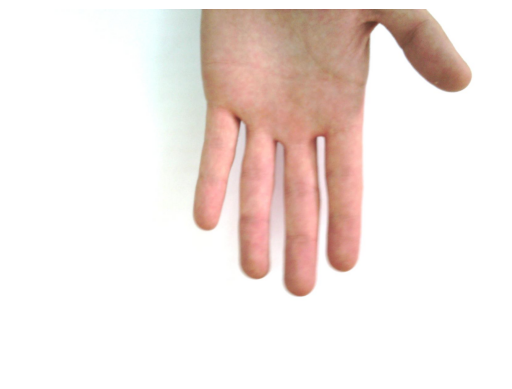

In [2]:
image = img.imread('G:/11k_hands/dataset/train/male/Hand_0000056.jpg')
plt.imshow(image)
plt.axis('off')

In [3]:
from guided_filter_pytorch.guided_filter import GuidedFilter

img = cv2.imread('G:/11k_hands/dataset/train/male/Hand_0000056.jpg')
grayscale_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_tensor = torch.from_numpy(img).float().permute(2, 0, 1).unsqueeze(0) / 255.0
gray_tensor = torch.from_numpy(grayscale_image).float().unsqueeze(0).unsqueeze(0) / 255.0

# Use the already defined hr_x (GuidedFilter instance)
hr_x = GuidedFilter(r=10, eps=0.01)
hrx = hr_x(gray_tensor, img_tensor)
hrx.shape

torch.Size([1, 3, 1200, 1600])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18744256..1.0000138].


torch.Size([1200, 1600, 3])


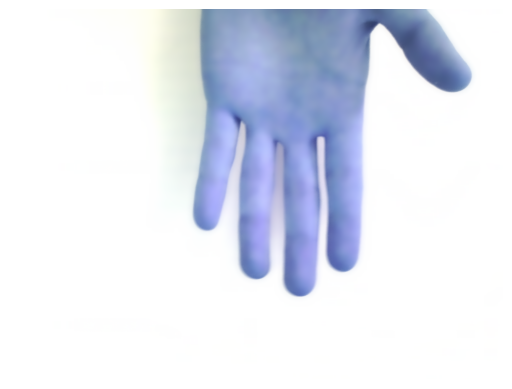

In [4]:
plt.imshow(hrx.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
print(hrx.squeeze(0).permute(1,2,0).shape)

In [5]:
# creating the detailed image 
image = img_tensor.squeeze(0).permute(1, 2, 0)
eps = np.full((1200, 1600, 3), 0.01)
eps_tensor = torch.from_numpy(eps).float().permute(0, 1, 2) 
low_frequency_image = hrx.squeeze(0).permute(1, 2, 0)
high_frequency_image = image/(low_frequency_image + eps_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.6419747..1.1737113].


torch.Size([1200, 1600, 3])


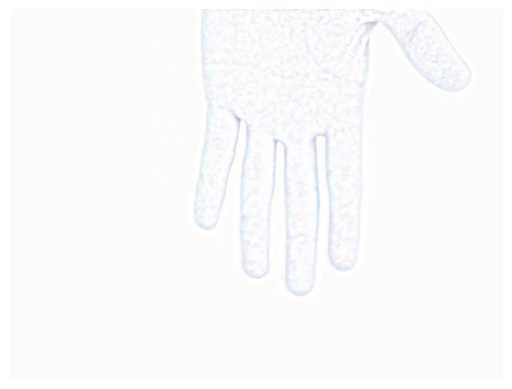

In [6]:
plt.imshow(high_frequency_image)
plt.axis('off')
print(high_frequency_image.shape)

In [7]:
import torchvision
from torchvision.models.alexnet import AlexNet_Weights

model = torchvision.models.alexnet(weights = AlexNet_Weights.DEFAULT)
conv_1 = model.features[0]

# get the weights of the 1st conv layer
weights = conv_1.weight
num_filters = weights.shape[0]
num_color_channels = weights.shape[1]

# change the shape of the conv_1 layer

before_luma_weights = torch.zeros(64, 3, 121)
for i in range(num_filters):
    temp = weights[i].reshape(weights[i].size(0), -1)
    before_luma_weights[i] = temp

In [8]:
# compute the luma weights
luma_weights = torch.zeros((num_filters, 121, 1))       ## initalize the luma_weights
luma_components = torch.tensor([[0.2989, 0.578, 0.114]])  ## luma components for RGB to grayscale conversion

for i in range(num_filters):
    temp = before_luma_weights[i].T @ luma_components.T
    luma_weights[i] = temp

In [9]:
model.features[0].weight = torch.nn.Parameter(luma_weights.reshape(64, 1, 11, 11))      # set the new luma weights to the conv2d_1 layer

In [10]:
from torch import nn
# implement the first stream 
class FirstStream(nn.Module):
    def __init__(self):
        super(FirstStream, self).__init__()
        
        # Load pretrained AlexNet
        alexnet = torchvision.models.alexnet(pretrained=AlexNet_Weights.DEFAULT)
        
        # Use AlexNet features (conv1 to conv5)
        self.features = alexnet.features  # Conv layers

        # Use AlexNet fc6 and fc7
        self.fc6 = alexnet.classifier[0]  # Linear(9216, 4096)
        self.relu6 = alexnet.classifier[1]
        self.dropout6 = alexnet.classifier[2]

        self.fc7 = alexnet.classifier[3]  # Linear(4096, 4096)
        self.relu7 = alexnet.classifier[4]
        self.dropout7 = alexnet.classifier[5]

        # Custom fc8 and fc9 layers
        self.fc8 = nn.Linear(4096, 2048)
        self.relu8 = nn.ReLU()
        self.dropout8 = nn.Dropout(p=0.5)

        self.fc9 = nn.Linear(2048, 531)
       # self.relu9 = nn.ReLU()
       # self.dropout9 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.features(x)              # conv1–conv5
        x = torch.flatten(x, 1)           # Flatten to (B, 9216)
        
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = self.fc7(x)
        x = self.relu7(x)
        x = self.dropout7(x)

        x = self.fc8(x)
        x = self.relu8(x)
        x = self.dropout8(x)

        x = self.fc9(x)
       # x = self.relu9(x)
       # x = self.dropout9(x)

        return x

In [11]:
resized_low_frequency_image = cv2.resize(low_frequency_image.detach().numpy(), (224, 224))  # Resize to 224x224
stream_1 = FirstStream()
stream_one_output = stream_1(torch.from_numpy(resized_low_frequency_image).float().unsqueeze(0).permute(0, 3, 1, 2))
print(stream_one_output.shape)  # (1, 531)

g:\11k_hands\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\11k_hands\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 531])


In [12]:
# implement the second stream
class SecondStream(nn.Module):
    def __init__(self):
        super(SecondStream, self).__init__()
        
        modified_alexnet = model
        
        self.features = modified_alexnet.features # conv layers
        
        # Use AlexNet fc6 and fc7
        self.fc6 = modified_alexnet.classifier[0]  # Linear(9216, 4096)
        self.relu6 = modified_alexnet.classifier[1]
        self.dropout6 = modified_alexnet.classifier[2]

        self.fc7 = modified_alexnet.classifier[3]  # Linear(4096, 4096)
        self.relu7 = modified_alexnet.classifier[4]
        self.dropout7 = modified_alexnet.classifier[5]
        
        self.fc8 = nn.Linear(4096, 2048)
        self.relu8 = nn.ReLU()
        self.dropout8 = nn.Dropout(p=0.5)
        
        self.fc9 = nn.Linear(2048, 2048)
        self.relu9 = nn.ReLU()
        self.dropout9 = nn.Dropout(p=0.5)
        
        self.fc10 = nn.Linear(2048, 531)
        
    def forward(self, x):
        x = self.features(x)
        
        x = torch.flatten(x, 1)  # Flatten to (B, 9216)
        
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.dropout6(x)
        
        x = self.fc7(x)
        x = self.relu7(x)
        x = self.dropout7(x)
        
        x = self.fc8(x)
        x = self.relu8(x)
        x = self.dropout8(x)
        
        x = self.fc9(x)
        x = self.relu9(x)
        x = self.dropout9(x)
        
        x = self.fc10(x)
        
        return x

In [13]:
Ih_yuv = cv2.cvtColor(high_frequency_image.detach().numpy(), cv2.COLOR_RGB2YUV)
Y = Ih_yuv[:, :, 0]
Y_normalized = (Y - Y.min()) / (Y.max() - Y.min())
Y_normalized.shape
#high_frequency_image = Y_normalized.reshape(1200, 1600, 1)  # Reshape to (1, 224, 224, 1)
#resized_high_frequency_image = cv2.resize(high_frequency_image, (224, 224)) 

(1200, 1600)

(np.float64(-0.5), np.float64(1599.5), np.float64(1199.5), np.float64(-0.5))

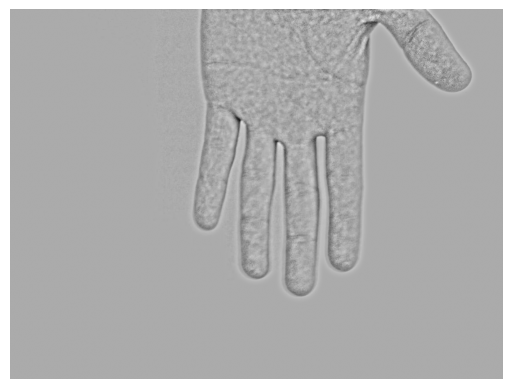

In [14]:
plt.imshow(Y_normalized, cmap='gray')
plt.axis('off')

In [15]:
resized_high_frequency_image = cv2.resize(Y_normalized, (224, 224))
resized_high_frequency_image = np.expand_dims(resized_high_frequency_image, axis=0)  # shape: (1, 224, 224)
resized_high_frequency_image = np.expand_dims(resized_high_frequency_image, axis=0)  # shape: (1, 1, 224, 224)
stream_2 = SecondStream()
stream_two_output = stream_2(torch.from_numpy(resized_high_frequency_image).float())
print(stream_two_output.shape)

torch.Size([1, 531])


In [16]:
fusion_input = np.concatenate((stream_one_output.detach().numpy(), stream_two_output.detach().numpy()), axis=1)
fusion_input_tensor = torch.from_numpy(fusion_input).float()

In [17]:
linear_model = nn.Sequential(
    nn.Linear(in_features=1062, out_features=1062),
    nn.Unflatten(1, (1, 1062)),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(in_features=531, out_features=2),
    nn.Softmax(dim=1),
   # nn.Sigmoid()
)

In [18]:
LM = linear_model
output = LM(fusion_input_tensor)
print(output.shape)  # Should be (1, 2)

torch.Size([1, 2])


In [19]:
output

tensor([[0.5175, 0.4825]], grad_fn=<SoftmaxBackward0>)

In [20]:
from torchinfo import summary

summary(
    SecondStream(),
    input_size=(1, 1, 224, 224),  # Pass the shape, not the tensor
    col_names=("input_size", "output_size", "num_params", "trainable"),
    verbose=2
)

summary(
    FirstStream(),
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params", "trainable"),
    verbose=2
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SecondStream                             [1, 1, 224, 224]          [1, 531]                  --                        True
├─Sequential: 1-1                        [1, 1, 224, 224]          [1, 256, 6, 6]            --                        True
│    └─0.weight                                                                              ├─7,744
│    └─0.bias                                                                                ├─64
│    └─3.weight                                                                              ├─307,200
│    └─3.bias                                                                                ├─192
│    └─6.weight                                                                              ├─663,552
│    └─6.bias                                                                                ├─384
│    └─8.weight     

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
FirstStream                              [1, 3, 224, 224]          [1, 531]                  --                        True
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 256, 6, 6]            --                        True
│    └─0.weight                                                                              ├─23,232
│    └─0.bias                                                                                ├─64
│    └─3.weight                                                                              ├─307,200
│    └─3.bias                                                                                ├─192
│    └─6.weight                                                                              ├─663,552
│    └─6.bias                                                                                ├─384
│    └─8.weight    

In [21]:
from torchvision import transforms
from pre_processing import img_converter
from torchvision.datasets import ImageFolder

IMG_SIZE = 224
BATCH_SIZE = 8

# override the ImageFolder to include the custom fucntion
class ImageFolderWithCustomTransform(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=None)  # disable transform for now
        self.base_transform = transform  # keep your transform pipeline without the custom fn

    def __getitem__(self, index):
        path, target = self.samples[index]

        # custom arg is the image itself in your case
        img = img_converter.createLowFrequencyComponent(path)  
        img = (img - img.min())/(img.max() - img.min())
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        
        if self.base_transform is not None:
            img = self.base_transform(img)

        return img, target
    
base_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

dataset = ImageFolderWithCustomTransform(root="G:/11k_hands/dataset/train", transform=base_transform)
dataloader_stream1 = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
classes = dataset.classes

In [22]:
classes, dataloader_stream1

(['female', 'male'], <torch.utils.data.dataloader.DataLoader at 0x204ff5189e0>)

In [23]:
image_batch, label_batch = next(iter(dataloader_stream1))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

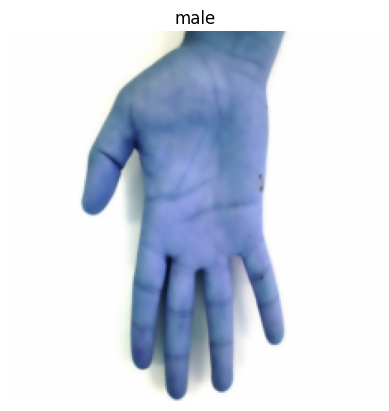

In [24]:
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.title(classes[label])
plt.axis(False)

Creating the modfified First stream for training

In [25]:
class ModifiedFirstStream(nn.Module):
    def __init__(self):
        super(ModifiedFirstStream, self).__init__()
        
        # Load pretrained AlexNet
        alexnet = torchvision.models.alexnet(pretrained=AlexNet_Weights.DEFAULT)
        
        # Use AlexNet features (conv1 to conv5)
        self.features = alexnet.features  # Conv layers

        # Use AlexNet fc6 and fc7
        self.fc6 = alexnet.classifier[0]  # Linear(9216, 4096)
        self.relu6 = alexnet.classifier[1]
        self.dropout6 = alexnet.classifier[2]

        self.fc7 = alexnet.classifier[3]  # Linear(4096, 4096)
        self.relu7 = alexnet.classifier[4]
        self.dropout7 = alexnet.classifier[5]

        # Custom fc8 and fc9 layers
        self.fc8 = nn.Linear(4096, 2048)
        self.relu8 = nn.ReLU()
        self.dropout8 = nn.Dropout(p=0.5)

        self.fc9 = nn.Linear(2048, 531)
        
        self.modfc = nn.Linear(531, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.features(x)              # conv1–conv5
        x = torch.flatten(x, 1)           # Flatten to (B, 9216)
        
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = self.fc7(x)
        x = self.relu7(x)
        x = self.dropout7(x)

        x = self.fc8(x)
        x = self.relu8(x)
        x = self.dropout8(x)

        x = self.fc9(x)
        x = self.modfc(x)
        x = self.softmax(x)

        return x

In [26]:
# training the modified first stream
import torch.optim as optim
import torch.nn.functional as F
import torch.cuda as cuda

device = torch.device("cuda" if cuda.is_available() else "cpu")

modified_first_stream = ModifiedFirstStream().to(device)

pretrained_params = (
    list(modified_first_stream.features.parameters()) 
    + list(modified_first_stream.fc6.parameters()) + list(modified_first_stream.relu6.parameters()) + list(modified_first_stream.dropout6.parameters()) 
    + list(modified_first_stream.fc7.parameters()) + list(modified_first_stream.relu7.parameters()) + list(modified_first_stream.dropout7.parameters()) 
    + list(modified_first_stream.fc8.parameters()) + list(modified_first_stream.relu8.parameters()) + list(modified_first_stream.dropout8.parameters()) 
    + list(modified_first_stream.fc9.parameters())
)

new_fc_params = list(modified_first_stream.modfc.parameters()) + list(modified_first_stream.softmax.parameters()) 

optimizer = optim.SGD([
    {'params': pretrained_params, 'lr': 1e-4},
    {'params': new_fc_params, 'lr': 0.002}
], momentum=0.9)

criterion = nn.CrossEntropyLoss()

In [27]:
num_epochs = 6

for epoch in range(num_epochs):
    modified_first_stream.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader_stream1:  
        images, labels = images.to(device), labels.to(device)

        outputs = modified_first_stream(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


KeyboardInterrupt: 